## Naive Bayes Modeli Eğitimi

Naive bayes modeli filtered veri seti ile eğitilir.

Naive Bayes için aşağıdaki parametreler denenmiştir.

| alpha | fit_prior | binarize |
|-------|-----------|----------|
| 0.1 | True | 0.0 |
| 0.5 | True | 0.5 |
| 1.0 | True | 1.0 |
| 1.0 | False | 0.0 |
| 2.0 | True | 0.5 |

En iyi parametreler:

| alpha | fit_prior |
|-------|-----------|
| 1.0 | False |

En iyi model başarımı aşağıdaki gibidir.

CV Sonuçları
|  | Accuracy | Precision | Recall | F1 Score |
|-----------------|----------|-----------|--------|----------|
| Ortalama | 0.9674 | 0.9602 | 0.9519 | 0.9560 |
| Standart Sapma | 0.0051 | 0.0071 | 0.0077 | 0.0069 |

Test Sonuçları
|  | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9624 | 0.9557 | 0.9430 | 0.9493 |


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import mlflow

def plot_and_log_confusion_matrix(y_true, y_pred, title, filename, figsize=(10,8)):
    """
    Confusion matrix oluşturur, görselleştirir ve MLflow'a kaydeder
    """
    # Confusion matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    
    plt.title(title)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    
    # Confusion matrix metriklerini MLflow'a kaydet
    mlflow.log_metrics({
        f"{title}_true_negatives": tn,
        f"{title}_false_positives": fp,
        f"{title}_false_negatives": fn,
        f"{title}_true_positives": tp
    })
    
    plt.show()
    
    # Metrikleri yazdır
    print(f"\n{title}")
    print(f"True Negatives (Güvenli doğru tahmin): {tn}")
    print(f"False Positives (Güvenli yanlış tahmin): {fp}")
    print(f"False Negatives (Oltalama yanlış tahmin): {fn}")
    print(f"True Positives (Oltalama doğru tahmin): {tp}")

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import joblib
import os

def train_and_evaluate_nb(train_data, test_data, dataset_name,
                         experiment_name, out_dir, nb_params, text_column='email_text'):
    """
    Naive Bayes modelini eğitir, değerlendirir ve sonuçları kaydeder.
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    # En iyi TF-IDF parametreleri
    tfidf_params = {
        'max_features': 5000,
        'ngram_range': (1, 2)
    }
    
    best_test_f1 = 0
    best_model = None
    best_vectorizer = None
    best_params = None

    os.makedirs(out_dir, exist_ok=True)
    for params in nb_params:
        with mlflow.start_run(run_name=f"NaiveBayes_{dataset_name}"):
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('nb', MultinomialNB(**params))
            ])
            
            cv_scores = cross_validate(pipeline, 
                                     train_data[text_column], 
                                     train_data['label'],
                                     cv=5,
                                     scoring=['accuracy', 'precision', 'recall', 'f1'])
            
            # Tüm train verisiyle eğit
            pipeline.fit(train_data[text_column], train_data['label'])
            
            test_pred = pipeline.predict(test_data[text_column])
            
            cv_metrics = {
                'cv_accuracy_mean': cv_scores['test_accuracy'].mean(),
                'cv_accuracy_std': cv_scores['test_accuracy'].std(),
                'cv_precision_mean': cv_scores['test_precision'].mean(),
                'cv_precision_std': cv_scores['test_precision'].std(),
                'cv_recall_mean': cv_scores['test_recall'].mean(),
                'cv_recall_std': cv_scores['test_recall'].std(),
                'cv_f1_mean': cv_scores['test_f1'].mean(),
                'cv_f1_std': cv_scores['test_f1'].std()
            }
            
    
            test_metrics = {
                'test_accuracy': accuracy_score(test_data['label'], test_pred),
                'test_precision': precision_score(test_data['label'], test_pred),
                'test_recall': recall_score(test_data['label'], test_pred),
                'test_f1': f1_score(test_data['label'], test_pred)
            }
            
            # MLflow'a parametreleri ve metrikleri kaydet
            mlflow.log_params({
                "dataset": dataset_name,
                **params,
                **tfidf_params
            })
            
            # En iyi modeli güncelle
            if test_metrics['test_f1'] > best_test_f1:
                best_test_f1 = test_metrics['test_f1']
                best_model = pipeline['nb']
                best_vectorizer = pipeline['tfidf']
                best_params = params
            

            
            plot_and_log_confusion_matrix(
                test_data['label'],
                test_pred,
                'Test Seti Confusion Matrix',
                os.path.join(out_dir, f"test_confusion_matrix_nb.png")
            )
            
            # Sonuçları yazdır
            print(f"\nModel parametreleri: {params}")
            print("\nCV metrikleri:")
            for metric, value in cv_metrics.items():
                print(f"{metric}: {value:.4f}")
        
            print(f"\nTest metrikleri:")
            for metric, value in test_metrics.items():
                print(f"{metric}: {value:.4f}")
    
    model_path = os.path.join(out_dir, f"{dataset_name}_nb.joblib")
    vectorizer_path = os.path.join(out_dir, f"{dataset_name}_tfidf.joblib")
    
    joblib.dump(best_model, model_path)
    joblib.dump(best_vectorizer, vectorizer_path)
    
    print(f"\nEn iyi model kaydedildi:")
    print(f"Model: {model_path}")
    print(f"Vectorizer: {vectorizer_path}")
    print(f"En iyi parametreler: {best_params}")
    
    return best_model, best_vectorizer

In [12]:
import pandas as pd
import os

# Veri setleri yüklenir
data_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "data")

filtered_train_data = pd.read_csv(os.path.join(data_dir, "filtered_train.csv"))
filtered_test_data = pd.read_csv(os.path.join(data_dir, "filtered_test.csv"))
print(f"filtered train data shape: {filtered_train_data.shape}")
print(f"filtered test data shape: {filtered_test_data.shape}")



filtered train data shape: (14353, 5)
filtered test data shape: (2630, 4)


In [13]:
# Naive Bayes için denenebilecek parametre setleri
nb_params = [
    # MultinomialNB için farklı alpha değerleri
    {'alpha': 0.1, 'fit_prior': True},
    {'alpha': 0.5, 'fit_prior': True},
    {'alpha': 1.0, 'fit_prior': True},
    {'alpha': 1.0, 'fit_prior': False},
    {'alpha': 2.0, 'fit_prior': True},

]

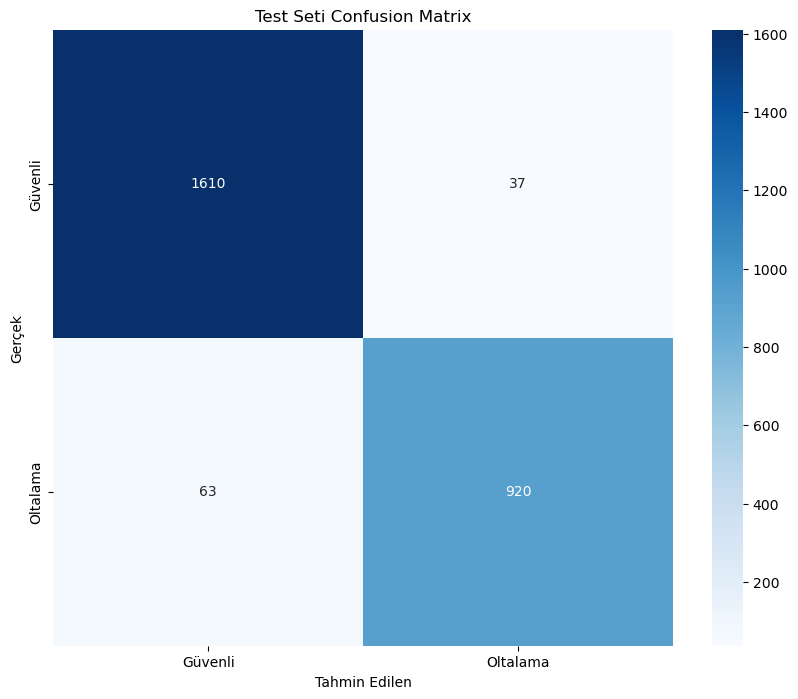


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1610
False Positives (Güvenli yanlış tahmin): 37
False Negatives (Oltalama yanlış tahmin): 63
True Positives (Oltalama doğru tahmin): 920

Model parametreleri: {'alpha': 0.1, 'fit_prior': True}

CV metrikleri:
cv_accuracy_mean: 0.9681
cv_accuracy_std: 0.0045
cv_precision_mean: 0.9640
cv_precision_std: 0.0069
cv_recall_mean: 0.9499
cv_recall_std: 0.0062
cv_f1_mean: 0.9569
cv_f1_std: 0.0061

Test metrikleri:
test_accuracy: 0.9620
test_precision: 0.9613
test_recall: 0.9359
test_f1: 0.9485


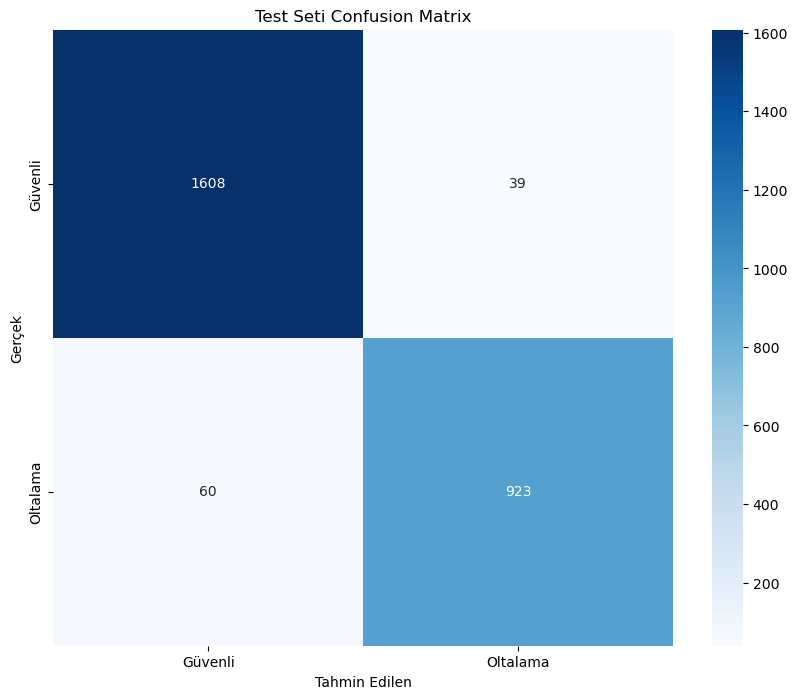


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1608
False Positives (Güvenli yanlış tahmin): 39
False Negatives (Oltalama yanlış tahmin): 60
True Positives (Oltalama doğru tahmin): 923

Model parametreleri: {'alpha': 0.5, 'fit_prior': True}

CV metrikleri:
cv_accuracy_mean: 0.9675
cv_accuracy_std: 0.0047
cv_precision_mean: 0.9609
cv_precision_std: 0.0065
cv_recall_mean: 0.9516
cv_recall_std: 0.0070
cv_f1_mean: 0.9562
cv_f1_std: 0.0064

Test metrikleri:
test_accuracy: 0.9624
test_precision: 0.9595
test_recall: 0.9390
test_f1: 0.9491


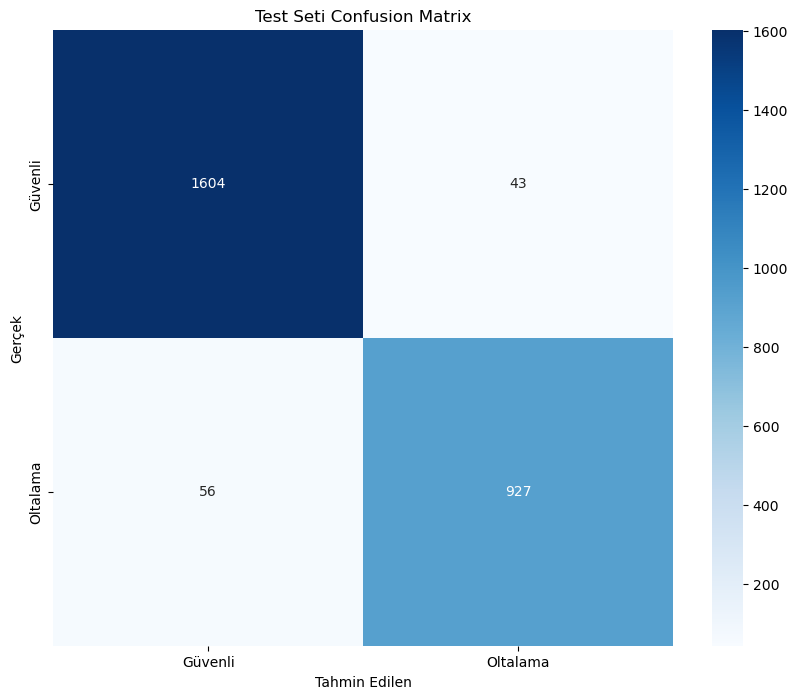


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1604
False Positives (Güvenli yanlış tahmin): 43
False Negatives (Oltalama yanlış tahmin): 56
True Positives (Oltalama doğru tahmin): 927

Model parametreleri: {'alpha': 1.0, 'fit_prior': True}

CV metrikleri:
cv_accuracy_mean: 0.9674
cv_accuracy_std: 0.0051
cv_precision_mean: 0.9602
cv_precision_std: 0.0071
cv_recall_mean: 0.9519
cv_recall_std: 0.0077
cv_f1_mean: 0.9560
cv_f1_std: 0.0069

Test metrikleri:
test_accuracy: 0.9624
test_precision: 0.9557
test_recall: 0.9430
test_f1: 0.9493


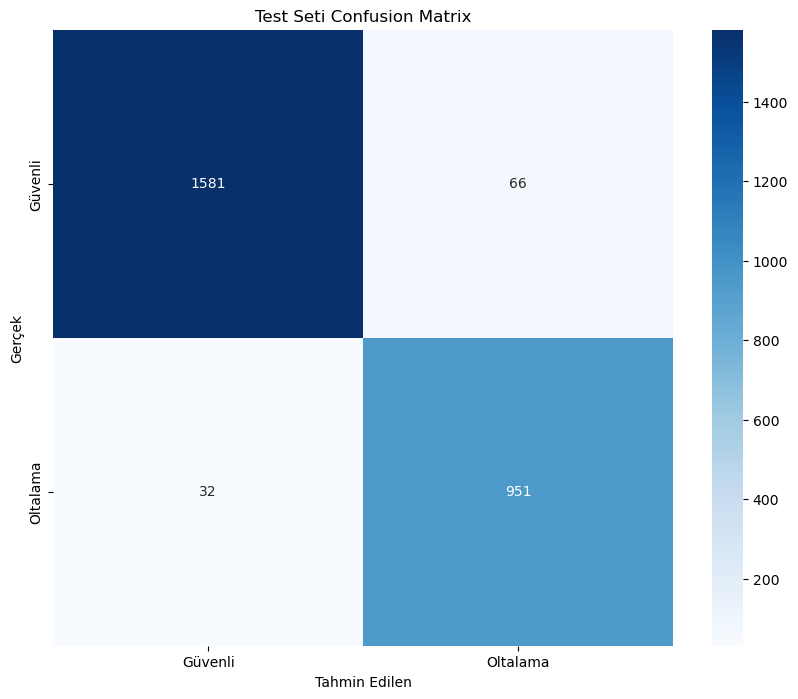


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1581
False Positives (Güvenli yanlış tahmin): 66
False Negatives (Oltalama yanlış tahmin): 32
True Positives (Oltalama doğru tahmin): 951

Model parametreleri: {'alpha': 1.0, 'fit_prior': False}

CV metrikleri:
cv_accuracy_mean: 0.9666
cv_accuracy_std: 0.0030
cv_precision_mean: 0.9393
cv_precision_std: 0.0031
cv_recall_mean: 0.9731
cv_recall_std: 0.0064
cv_f1_mean: 0.9559
cv_f1_std: 0.0041

Test metrikleri:
test_accuracy: 0.9627
test_precision: 0.9351
test_recall: 0.9674
test_f1: 0.9510


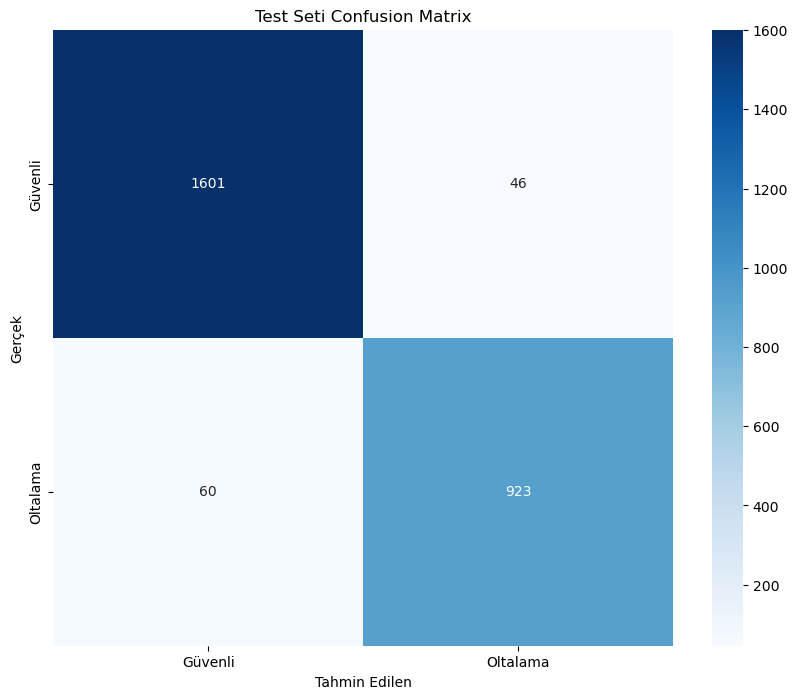


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1601
False Positives (Güvenli yanlış tahmin): 46
False Negatives (Oltalama yanlış tahmin): 60
True Positives (Oltalama doğru tahmin): 923

Model parametreleri: {'alpha': 2.0, 'fit_prior': True}

CV metrikleri:
cv_accuracy_mean: 0.9664
cv_accuracy_std: 0.0044
cv_precision_mean: 0.9605
cv_precision_std: 0.0069
cv_recall_mean: 0.9489
cv_recall_std: 0.0063
cv_f1_mean: 0.9547
cv_f1_std: 0.0060

Test metrikleri:
test_accuracy: 0.9597
test_precision: 0.9525
test_recall: 0.9390
test_f1: 0.9457

En iyi model kaydedildi:
Model: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/naive_bayes/filtered_nb.joblib
Vectorizer: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/naive_bayes/filtered_tfidf.joblib
En iyi parametreler: {'alpha': 1.0, 'fit_prior': False}


In [14]:
model_dir = os.path.join(os.path.dirname(os.getcwd()),"source", "models", "naive_bayes")
# Modeli eğit
best_model, best_vectorizer = train_and_evaluate_nb(
    train_data=filtered_train_data,
    test_data=filtered_test_data,
    dataset_name="filtered",
    experiment_name="NaiveBayes-experiments",
    out_dir=model_dir,
    nb_params=nb_params
)